In [145]:
import pandas as pd
import numpy as np
import random as rnd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# EDA

In [87]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
PassengerId = test['PassengerId']

train.dropna(axis=0, subset=['Survived'], inplace=True)
y_train = train.Survived
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

full_data = pd.concat([train, test]).reset_index(drop=True)

In [88]:
full_data.shape

(1309, 11)

In [89]:
full_data.head

<bound method NDFrame.head of       Survived  Pclass                                               Name  \
0          0.0       3                            Braund, Mr. Owen Harris   
1          1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2          1.0       3                             Heikkinen, Miss. Laina   
3          1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4          0.0       3                           Allen, Mr. William Henry   
...        ...     ...                                                ...   
1304       NaN       3                                 Spector, Mr. Woolf   
1305       NaN       1                       Oliva y Ocana, Dona. Fermina   
1306       NaN       3                       Saether, Mr. Simon Sivertsen   
1307       NaN       3                                Ware, Mr. Frederick   
1308       NaN       3                           Peter, Master. Michael J   

         Sex   Age  SibSp  Parch             

In [90]:
full_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [91]:
print(full_data.columns.values)

['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


# ***Data Analysis***

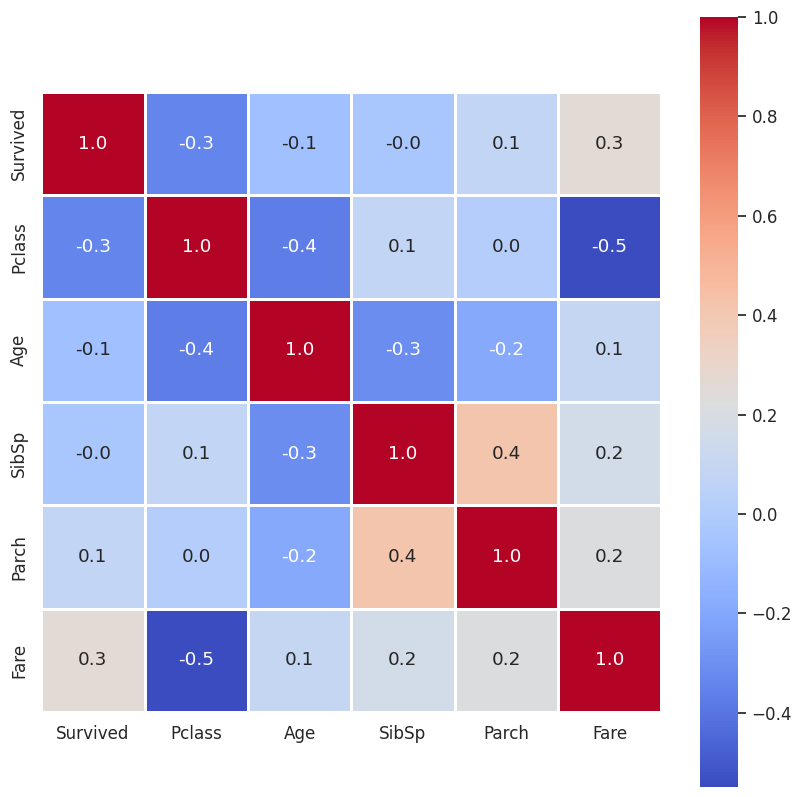

In [92]:
sns.set(font_scale=1.1)
correlation_train = train.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.01f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=True)

plt.show()

In [93]:
train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Analysis of pearson correlation
* Survival is correlated to fare and class. Currently, important factors such as sex are not numerical. They are "M" and "F", not 0 and 1 so we will do these in the feature engineering section.

## Missing Data

In [94]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Cabin,Age,Embarked,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
Total,687.000000,177.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Percent,77.104377,19.865320,0.224467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


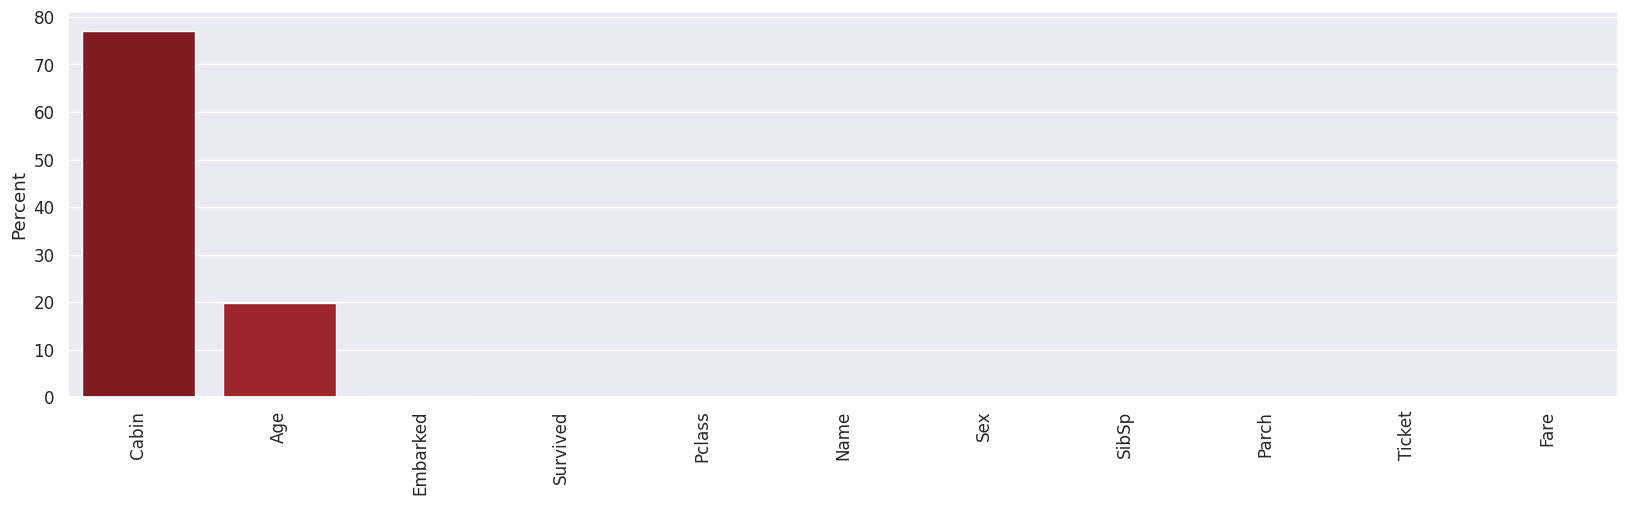

In [95]:
missing = missing_percentage(train)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

<Axes: xlabel='Pclass', ylabel='Age'>

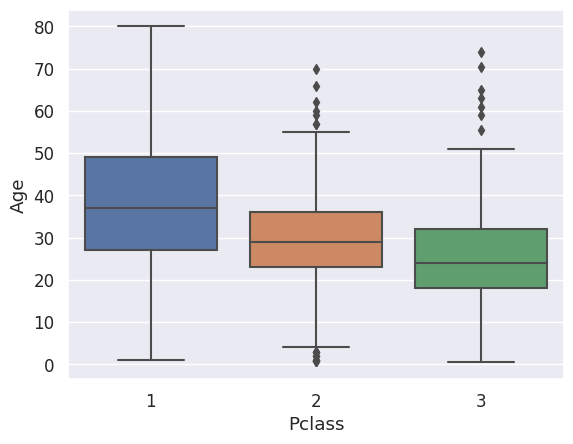

In [96]:
sns.boxplot(x='Pclass',y='Age',data=train)

* Since 'Age' and 'Pclass' are correlated, we can fill the missing values in 'Age' with the mean age corresponding to each 'Pclass'.

In [97]:
mean_age_by_pclass = full_data.groupby('Pclass')['Age'].mean()
print("\nMean Age by Pclass:")
print(mean_age_by_pclass)


Mean Age by Pclass:
Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64


In [98]:
def fill_missing_age(df):
    mean_age_by_pclass = df.groupby('Pclass')['Age'].transform('mean')
    
    df['Age'] = df['Age'].fillna(mean_age_by_pclass)
    
    return df

full_data = fill_missing_age(full_data)

print("\nAfter filling missing values, number of missing 'Age' values:")
print(full_data['Age'].isnull().sum())


After filling missing values, number of missing 'Age' values:
0


* Why would "Embarked" be missing? There's no apparent reason, so let's impute with the most common, "S".

In [99]:
most_common_embarked = full_data['Embarked'].mode()[0]
print("Most common value in 'Embarked':", most_common_embarked)

Most common value in 'Embarked': S


In [100]:
full_data['Embarked'].fillna(most_common_embarked, inplace=True)

print("\nAfter filling missing 'Embarked' values, number of missing 'Embarked' values:")
print(full_data['Embarked'].isnull().sum())


After filling missing 'Embarked' values, number of missing 'Embarked' values:
0


Now we are left with Cabin column.
I'm assuming that if there is no cabin number, then they don't have a cabin. 
So, I will replace Cabin with HasCabin in Feature Engineering part, that says whether they have a cabin or not.

In [101]:
full_data['Fare'].fillna(train['Fare'].median(), inplace=True)

In [102]:
full_data.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
dtype: int64

# ***Feature Engineering***

* New features

In [103]:
full_data['HasCabin'] = full_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

In [104]:
full_data.groupby(['HasCabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,HasCabin,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [105]:
full_data.isnull().sum()

Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1014
Embarked         0
HasCabin         0
FamilySize       0
IsAlone          0
dtype: int64

* Mapping features

In [106]:
full_data['Name_Length'] = full_data['Name'].apply(lambda x: len(x))

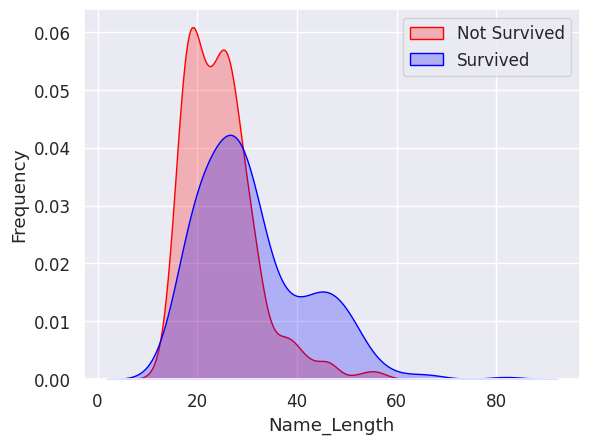

In [107]:
g = sns.kdeplot(full_data['Name_Length'][(full_data['Survived']==0) & (full_data['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(full_data['Name_Length'][(full_data['Survived']==1) & (full_data['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [108]:
full_data['Name_LengthGB'] = pd.qcut(full_data['Name_Length'], 3)

In [109]:
full_data.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

,Name_LengthGB,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [110]:
full_data.loc[full_data['Name_Length'] <= 22, 'Name_Size'] = 0
full_data.loc[(full_data['Name_Length'] > 22) & (full_data['Name_Length'] <= 28), 'Name_Size'] = 1
full_data.loc[(full_data['Name_Length'] > 28) & (full_data['Name_Length'] <= 82), 'Name_Size'] = 2
full_data.loc[full_data['Name_Length'] > 82, 'Name_Size']

Series([], Name: Name_Size, dtype: float64)

In [111]:
full_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone,Name_Length,Name_LengthGB,Name_Size
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,23,"(22.0, 28.0]",1.0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,51,"(28.0, 82.0]",2.0
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,22,"(11.999, 22.0]",0.0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,44,"(28.0, 82.0]",2.0
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,24,"(22.0, 28.0]",1.0


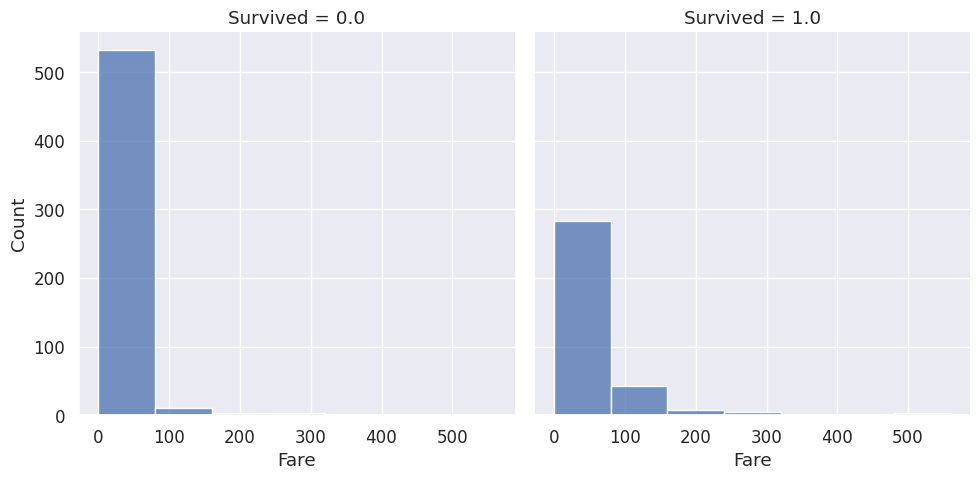

In [112]:
sns.displot(full_data, x='Fare', col='Survived', binwidth=80, height=5)

In [113]:
full_data['Fare_Cut'] = pd.qcut(full_data['Fare'], 5)

In [114]:
full_data.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()

,Fare_Cut,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.558]",0.426901
3,"(21.558, 41.579]",0.443243
4,"(41.579, 512.329]",0.645349


In [115]:
full_data.loc[full_data['Fare'] <= 7.854, 'Fare'] = 0
full_data.loc[(full_data['Fare'] > 7.854) & (full_data['Fare'] <= 10.5), 'Fare'] = 1
full_data.loc[(full_data['Fare'] > 10.5) & (full_data['Fare'] <= 21.679), 'Fare'] = 2
full_data.loc[(full_data['Fare'] > 21.679) & (full_data['Fare'] <= 39.688), 'Fare'] = 3
full_data.loc[(full_data['Fare'] > 39.688) & (full_data['Fare'] <= 512.329), 'Fare'] = 4
full_data.loc[full_data['Fare'] > 512.329, 'Fare']

258     512.3292
679     512.3292
737     512.3292
1234    512.3292
Name: Fare, dtype: float64

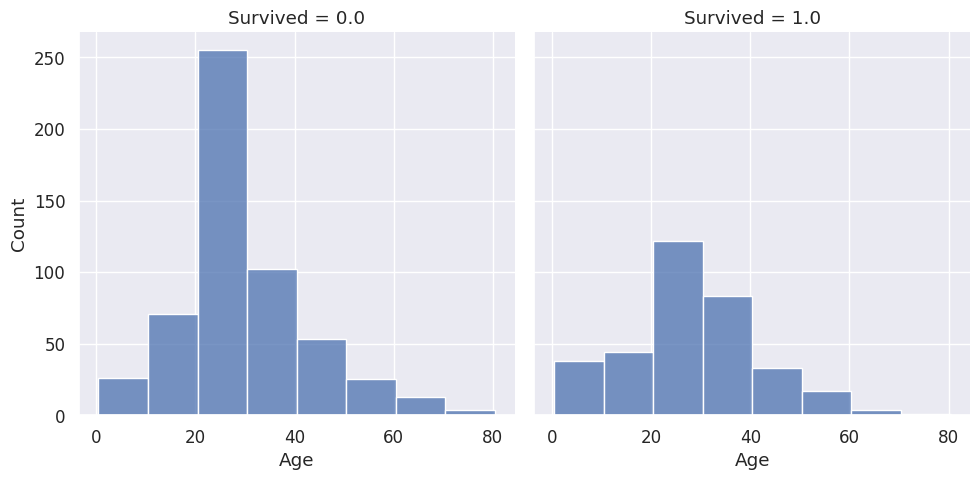

In [116]:
sns.displot(full_data, x='Age', col='Survived', binwidth=10, height=5)

In [117]:
full_data['Age_Cut'] = pd.qcut(full_data['Age'], 5)

In [118]:
full_data.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

,Age_Cut,Survived
0,"(0.169, 21.0]",0.426471
1,"(21.0, 24.816]",0.309524
2,"(24.816, 29.507]",0.358974
3,"(29.507, 39.16]",0.441624
4,"(39.16, 80.0]",0.374233


In [119]:
full_data.loc[full_data['Age'] <= 19, 'Age'] = 0
full_data.loc[(full_data['Age'] > 19) & (full_data['Age'] <= 25), 'Age'] = 1
full_data.loc[(full_data['Age'] > 25) & (full_data['Age'] <= 31.8), 'Age'] = 2
full_data.loc[(full_data['Age'] > 31.8) & (full_data['Age'] <= 41), 'Age'] = 3
full_data.loc[(full_data['Age'] > 41) & (full_data['Age'] <= 80), 'Age'] = 4
full_data.loc[full_data['Age'] > 80, 'Age']

Series([], Name: Age, dtype: float64)

In [120]:
full_data['Sex'] = full_data['Sex'].map({'female': 0, 'male': 1})

full_data['Embarked'] = full_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

* Deleting: Name, Ticket and Cabin

In [121]:
full_data.isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin            1014
Embarked            0
HasCabin            0
FamilySize          0
IsAlone             0
Name_Length         0
Name_LengthGB       0
Name_Size           0
Fare_Cut            0
Age_Cut             0
dtype: int64

In [122]:
full_data.drop(columns=['Ticket', 'Cabin', 'Name', 'Name_Length', 'Fare_Cut', 'Age_Cut', 'Parch', 'SibSp', 'Name_LengthGB'], inplace=True)
full_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,FamilySize,IsAlone,Name_Size
0,0.0,3,1,1.0,0.0,0,0,2,0,1.0
1,1.0,1,0,3.0,4.0,1,1,2,0,2.0
2,1.0,3,0,2.0,1.0,0,0,1,1,0.0
3,1.0,1,0,3.0,4.0,0,1,2,0,2.0
4,0.0,3,1,3.0,1.0,0,0,1,1,1.0
5,0.0,3,1,1.0,1.0,2,0,1,1,0.0
6,0.0,1,1,4.0,4.0,0,1,1,1,1.0
7,0.0,3,1,0.0,2.0,0,0,5,0,2.0
8,1.0,3,0,2.0,2.0,0,0,3,0,2.0
9,1.0,2,0,0.0,3.0,1,0,2,0,2.0


In [123]:
full_data.isnull().sum()

Survived      418
Pclass          0
Sex             0
Age             0
Fare            0
Embarked        0
HasCabin        0
FamilySize      0
IsAlone         0
Name_Size       0
dtype: int64

# Final splitting and checking data

In [124]:
train = full_data.iloc[:len(train), :]
test = full_data.iloc[len(train):, :]

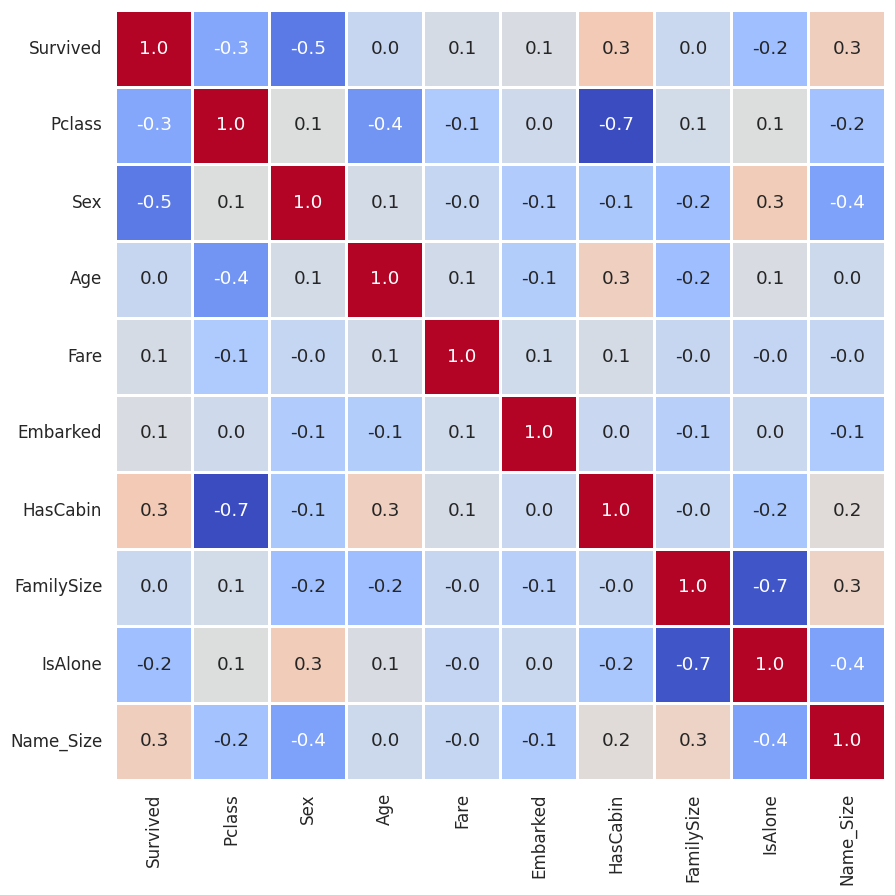

In [125]:
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.01f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=False)

plt.show()

Analysis of pearson correlation
* Sex is the largest determiner of survival.
* Other than that, pclass, fare, cabin, and being alone have a high correlation. 

In [126]:
missing = missing_percentage(train)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,FamilySize,IsAlone,Name_Size
Total,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [127]:
train.drop(['Survived'], axis=1, inplace=True)
test.drop(['Survived'], axis=1, inplace=True)

# Models

In [146]:
model_xgb = XGBClassifier()
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_svc = SVC()

In [147]:
param_dist_xgb = {
    'model__n_estimators': np.arange(100, 500, 50),
    'model__gamma': np.linspace(0, 1, 10),
    'model__eta': np.logspace(-3, 0, 4),
    'model__learning_rate': np.linspace(0.01, 0.1, 10),
    'model__max_depth': np.arange(3, 15, 1),
    'model__subsample': np.linspace(0.5, 1.0, 6),
    'model__colsample_bytree': np.linspace(0.5, 1.0, 6),
    'model__min_child_weight': np.arange(1, 10, 1)
}

param_dist_lr = {
    'model__C': np.logspace(-3, 3, 7),
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

param_dist_rf = {
    'model__n_estimators': np.arange(100, 500, 50),
    'model__max_depth': np.arange(5, 20, 2),
    'model__min_samples_split': np.arange(2, 10, 2),
    'model__min_samples_leaf': np.arange(1, 10, 1)
}

param_dist_knn = {
    'model__n_neighbors': np.arange(3, 20, 2),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

param_dist_svc = {
    'model__C': np.logspace(-3, 3, 7),
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

In [149]:
pipelines = {
    'xgb': Pipeline(steps=[('model', model_xgb)]),
    'lr': Pipeline(steps=[('model', model_lr)]),
    'rf': Pipeline(steps=[('model', model_rf)]),
    'knn': Pipeline(steps=[('model', model_knn)]),
    'svc': Pipeline(steps=[('model', model_svc)])
}

In [150]:
random_searches = {
    'xgb': RandomizedSearchCV(
        pipelines['xgb'], param_distributions=param_dist_xgb, n_iter=10, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    ),
    'lr': RandomizedSearchCV(
        pipelines['lr'], param_distributions=param_dist_lr, n_iter=10, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    ),
    'rf': RandomizedSearchCV(
        pipelines['rf'], param_distributions=param_dist_rf, n_iter=10, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    ),
    'knn': RandomizedSearchCV(
        pipelines['knn'], param_distributions=param_dist_knn, n_iter=10, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    ),
    'svc': RandomizedSearchCV(
        pipelines['svc'], param_distributions=param_dist_svc, n_iter=10, cv=5,
        scoring='accuracy', verbose=1, random_state=42, n_jobs=-1
    )
}

In [151]:
for model_name, random_search in random_searches.items():
    print(f"Training {model_name}...")
    random_search.fit(train, y_train)
    print(f"Best hyperparameters for {model_name}:")
    print(random_search.best_params_)

scores = {}
for model_name, random_search in random_searches.items():
    scores[model_name] = cross_val_score(random_search.best_estimator_, train, y_train, cv=5, scoring='accuracy')
    print(f"Average accuracy for {model_name}: {scores[model_name].mean()}")

best_model_name = max(scores, key=lambda model_name: scores[model_name].mean())
best_model = random_searches[best_model_name].best_estimator_

print(f"\nBest model: {best_model_name} with average accuracy: {scores[best_model_name].mean()}")

Training xgb...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for xgb:
{'model__subsample': 0.6, 'model__n_estimators': 150, 'model__min_child_weight': 3, 'model__max_depth': 8, 'model__learning_rate': 0.09000000000000001, 'model__gamma': 1.0, 'model__eta': 1.0, 'model__colsample_bytree': 1.0}
Training lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for lr:
{'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 100.0}
Training rf...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for rf:
{'model__n_estimators': 400, 'model__min_samples_split': 4, 'model__min_samples_leaf': 5, 'model__max_depth': 13}
Training knn...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for knn:
{'model__weights': 'uniform', 'model__n_neighbors': 15, 'model__metric': 'manhattan'}
Training svc...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
B

In [152]:
preds_test = best_model.predict(test)

output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': preds_test})

output.to_csv('submission.csv', index=False)